# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
# image libraries
from PIL import Image, ImageChops
import cv2
from keras.preprocessing.image import ImageDataGenerator, random_shear, random_zoom

from skimage.util import random_noise
from skimage.util import img_as_float


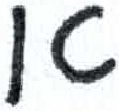

In [100]:
# this is the original image I will be using to compare against
img = Image.open("0_189.png")
width, height = img.size
img

In [98]:
img = img.crop((-100,0,200,300))

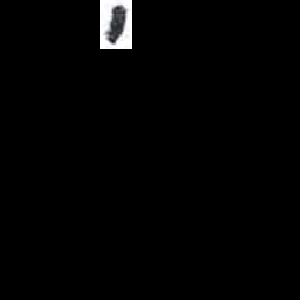

In [99]:
img

# Adding Noise to Images

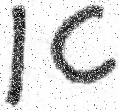

In [82]:
from skimage.util import random_noise
from skimage.util import img_as_float

im_float = img_as_float(img)

im_noise = random_noise(im_float, mode='s&p', amount=.2,salt_vs_pepper=.95)
im_noise = Image.fromarray((im_noise * 255).astype(np.uint8))
# this changes the image to black and white
im_noise = im_noise.convert('L')
im_noise

# Functions for Image Generation

For the image generation I decided to use image affine from last week as I feel that provided the best variation of images.

In [83]:
def add_noise(img, amount = .2, salt_vs_pepper = .95):
    im_float = img_as_float(img)
    im_noise = random_noise(im_float, mode='s&p', amount=.2,salt_vs_pepper=.95)
    im_noise = Image.fromarray((im_noise * 255).astype(np.uint8))
    # change the image to black and white
    im_noise = im_noise.convert('L')
    return im_noise

def image_affine(image, intensity = 30):
    width, height = image.size
    width, height = image.size
    
    # inverts the image. This is done because the background is white and the text is black
    # and editing the image with the background as black and the text as white is easier
    im = ImageChops.invert(img)
   
    # turn im into cv2 image in order to use cv2 functions
    im = np.array(im)
    im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
    
    # these three points represent three corners of the image (top left, top right, bottom left)
    pt1 = np.float32([[0,0],[width,0],[0,height]])
    
    # choose random points based on the intensity parameter
    pt2 = np.float32([[np.random.randint(0, intensity),np.random.randint(0, intensity)],
                      [np.random.randint(width-intensity, width),np.random.randint(0, intensity)],
                      [np.random.randint(0, intensity),np.random.randint(height-intensity, height)]])
    
    M = cv2.getAffineTransform(pt1, pt2)
    rows, cols, ch = im.shape
    dst = cv2.warpAffine(im, M, (cols, rows))

    
    
    return cv2.bitwise_not(dst)

def image_generator(image, im_num = 1, intensity = 30, noise = True, affine = True, noise_amount = .2, salt_vs_pepper = .95):
    # im_num is the number of images you want to generate
    # intensity is the intensity of the affine transformation
    # noise is a boolean that determines whether or not to add noise to the image
    # affine is a boolean that determines whether or not to apply an affine transformation to the image
    images = []
    for i in range(im_num):
        if affine == True:
            image = image_affine(image, intensity)
        if noise == True:
            image = add_noise(image, noise_amount, salt_vs_pepper)
        images.append(image)

    return images

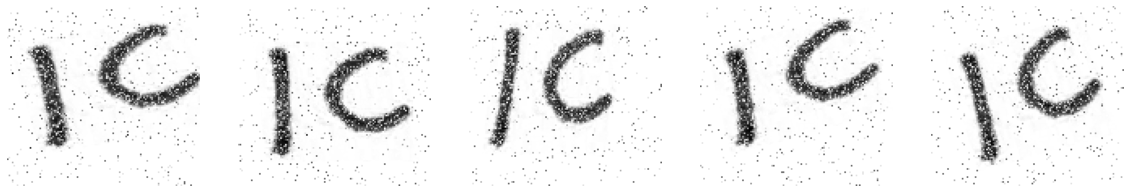

In [84]:
images = image_generator(img, im_num = 5, intensity = 30, noise = True, affine = True)

fig, ax = plt.subplots(1, 5, figsize=(20, 20))
for i in range(5):
    ax[i].imshow(images[i], cmap='gray')
    ax[i].axis('off')

# Going through the Dataset

In [56]:
# the dataset folder is called hhd_dataset_cleaned. In that folder there is the TRAIN and TEST folders,
# here I will go through the train folder and generate images for each image in the folder and save them in a new folder called TRAIN_GENERATED

import os
import shutil

# this is the folder that contains the original images
original_folder = './hhd_dataset_cleaned/TRAIN'

# this is the folder that will contain the generated images
generated_folder = './hhd_dataset_cleaned/TRAIN_GENERATED'

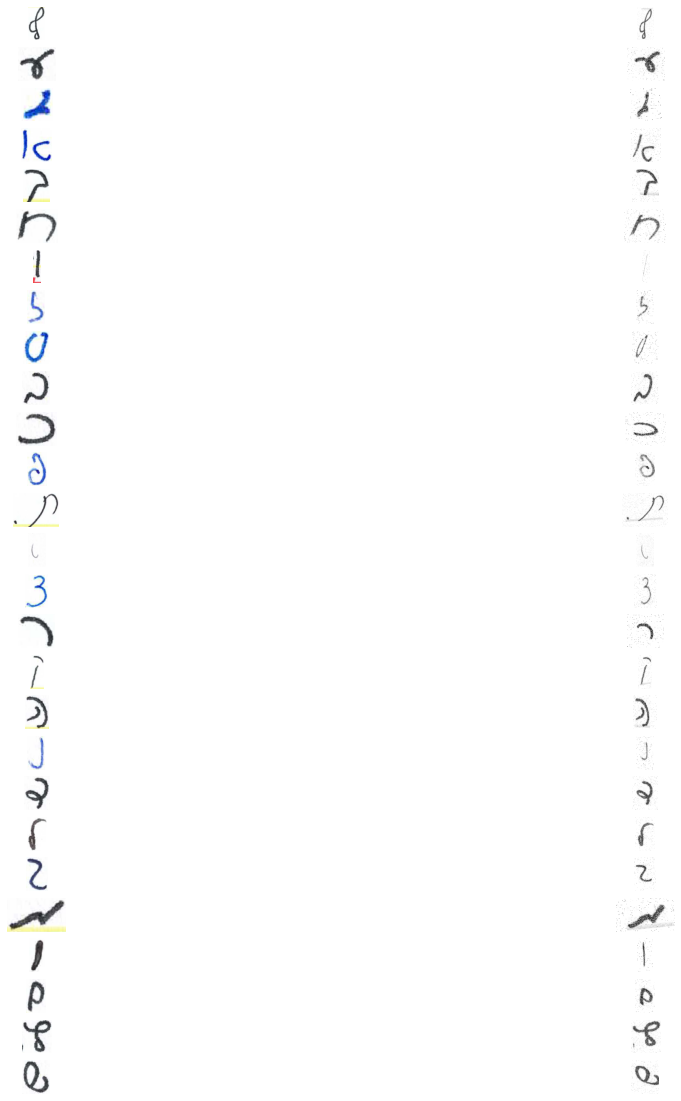

In [77]:
generated = []
for folderename in os.listdir(original_folder):
    for filename in os.listdir(original_folder + '/' + folderename):
         # get the first image in the folder and generate 1 image
        img = Image.open(original_folder + '/' + folderename + '/' + filename)
        images = image_generator(img, im_num = 1, intensity = 30, noise = True, affine = True)
        generated.append((img, images[0]))
        break

        
# plot each of the 27 generated images next to the original image
fig, ax = plt.subplots(27, 2, figsize=(20, 20))
for i in range(27):
    ax[i, 0].imshow(generated[i][0], cmap='gray')
    ax[i, 0].axis('off')
    ax[i, 1].imshow(generated[i][1], cmap='gray')
    ax[i, 1].axis('off')
    



In [58]:
for folderename in os.listdir(original_folder):
    for filename in os.listdir(original_folder + '/' + folderename):
        if filename.endswith(".png"):
            img = Image.open(original_folder + '/' + folderename + '/' + filename)
            images = image_generator(img, im_num = 5, intensity = 30, noise = True, affine = True)
            for i in range(5):
                # make sure the path exists
                if not os.path.exists(generated_folder + '/' + folderename):
                    os.makedirs(generated_folder + '/' + folderename)
                images[i].save(generated_folder + '/' + folderename + '/' + filename[:-4] + '_' + str(i) + '.png')
        else:
            continue